<a href="https://colab.research.google.com/github/prav2909/Machine-Learning/blob/master/RandomForest_on_Titanic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author : Praveen Kumar

In [ ]:
\
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier


def load_dataset(path):
    import pandas as pd
    from sklearn.model_selection import train_test_split

    df = pd.read_csv('titanic.csv')

    df['Title'] = df['Name'].str.extract(' ([a-zA-Z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    # We map the Title attribute to a one-hot encoding.
    df = df.join(pd.get_dummies(df['Title'], prefix='Title'))

    # We map the Sex attribute to a numeric representation.
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 0}).astype(int)

    # We one-hot encode Pclass.
    df = df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))

    # Based on the number of sibling-spouses in SibSp and parents-childern in Parch, 
    # we can determine whether a passenger was on board alone.
    df['IsAlone'] = ((df['SibSp'] + df['Parch'] + 1) == 1).astype(int)

    # We remove all attributes that do not seem relevant to the prediction, or are already encoded in another attribute.
    df = df.drop(['PassengerId', 'Name', 'Title', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1)

    # For remaining features, we have to separate train and test, 
    # as we will impute missing data based on statistics in the training data.
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=2020)
    # For Embarked, we set all missing values to the most frequent port and then one-hot encode the attribute.
    def impute_embarked():    
        freq_port = df_train['Embarked'].dropna().mode()[0]
        output = []
        for df in (df_train, df_test):
            df = df.join(pd.get_dummies(df['Embarked'].fillna(freq_port), prefix='Embarked'))
            df = df.drop('Embarked', axis=1)
            output.append(df)
        return output

    df_train, df_test = impute_embarked()

    # For Age, we set missing values to the median dependent on the pair of Sex and Pclass.
    guess_ages = np.zeros((2, 3))
    for df in (df_train, df_test):
        for i in range(2):
            for j in range(3):
                guess_ages[i, j] = df[(df['Sex'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()
        for i in range(2):
            for j in range(3):
                df.loc[(df['Age'].isnull()) & (df['Sex'] == i) & (df['Pclass'] == j+1), 'Age'] = guess_ages[i, j]
        df['Age'] = df['Age'].astype(int)

    df_train = df_train.drop(['Pclass'], axis=1) 
    df_test = df_test.drop(['Pclass'], axis=1)

    X_train = df_train.values[:, 1:]

    X_test = df_test.values[:, 1:]
    y_train = df_train.values[:, 0]
    y_test = df_test.values[:, 0]
    
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = load_dataset('titanic.csv')


The Titanic dataset and a description can be found at [Kaggle](https://www.kaggle.com/c/titanic/data). The feature engineering mostly follows the work by [Manav Segal](https://www.kaggle.com/startupsci/titanic-data-science-solutions). 

The prepared dataset contains the following attributes:
- Sex: binary (0 = Male, 1 = Female)
- Age: integer
- Fare: float
- Title_{Master, Miss, Mr, Mrs, Rare}: title of passenger (extracted from name), binary, one-hot encoding of categorical variable Title
- Pclass_{1, 2, 3}: ticket class corresponds to socio-economic status (1 = upper class, 2 = middle class, 3 = lower class), binary, one-hot encoding of categorical variable Pclass
- IsAlone: whether the passenger has no siblings/spouses/parents/children on board, binary
- Embarked_{C, Q, S}: port at which passenger embarked (C = Cherbourg, Q = Queenstown, S = Southampton), binary, one-hot encoding of categorical variable Embarked

The classification target is:
- Survived: binary

Data is split into train-test with a 80-20 ratio yielding 712 training and 179 test samples. Train and test data is stored in the variables `(X_train, y_train)` and `(X_test, y_test)` respectively.

## Random Forest

In this task, you will implement a random forest classifier using the scikit-learn implementation of the decision tree. 

Using bootstrap sampling and sample 20% of the original data set for each tree. Randomly select 6 attributes/columns for each trained tree. The prediction of each tree is weighted equally in the majority vote. Using the already imported class `DecisionTreeClassifier` for your decision trees. 

We will evaluate the model on the test data using scikit-learn with the confusion matrix 


In [ ]:
class RandomForestClassifier(object):
    def __init__(self, number_of_trees):
        self.number_of_trees = number_of_trees
        self.forest = []
        
    def fit(self, X, y):
      # Implemented training here.
        clf = DecisionTreeClassifier(random_state=0)
        for i in range(self.number_of_trees):
          bootstrap_indices = np.random.randint(low=0, high=len(X_train), size=int(len(X_train)*0.20))
          idx_col = np.random.choice(15, size = 6, replace = False)

          data_bootstrapped = X[bootstrap_indices]
          y_bootstrapped = y[bootstrap_indices]
          data_bootstrapped_up = np.transpose(data_bootstrapped)
          data_bootstrapped_up = data_bootstrapped_up[idx_col]
          data_bootstrapped_up = np.transpose(data_bootstrapped_up)

          clf = DecisionTreeClassifier()
          clf = clf.fit(data_bootstrapped_up,y_bootstrapped)

          self.forest.append(clf)

        
        pass
    
    def predict(self, X):
        # Implemented prediction here.
        a = 0
        b = 0
        X = X[0][0:6]
        X = X.reshape(1,-1)
        for i in range(len(self.forest)):
          clf = self.forest[i]
          y_pred = clf.predict(X) 
          if y_pred == 1:
            a += 1
          elif y_pred == 0:
            b += 1

        if(a>=b):
          return 1
        elif(b>a):
          return 0

        

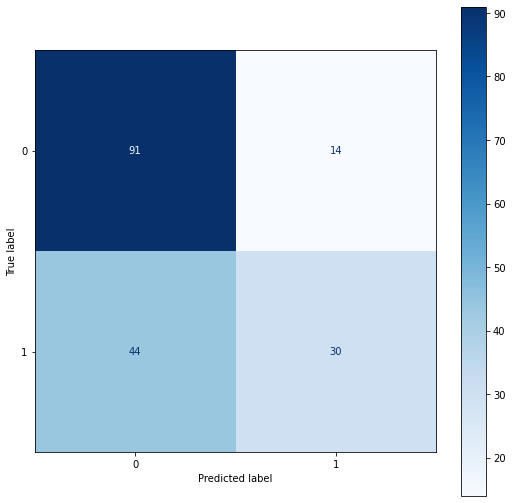

In [ ]:
# Implemented training and evaluation here.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


number_of_trees = 200
forestClf = RandomForestClassifier(number_of_trees)
forestClf.fit(X_train, y_train)

#Training
pred_data = []
for i in range(len(X_test)):
  X_test_rows = X_test[i]
  X_test_rows = X_test_rows.reshape(1,-1)
  x_pred = forestClf.predict(X_test_rows)
  pred_data.append(x_pred)

#Predicting
cm = confusion_matrix(y_test, pred_data)
target_names = ['0', '1']

cm_display = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(9,9))
cm_display.plot(cmap = 'Blues', ax = ax)